# 电影评论文本分类

Note: 我们的 TensorFlow 社区翻译了这些文档。因为社区翻译是尽力而为， 所以无法保证它们是最准确的，并且反映了最新的
[官方英文文档](https://tensorflow.google.cn/?hl=en)。如果您有改进此翻译的建议， 请提交 pull request 到
[tensorflow/docs](https://github.com/tensorflow/docs) GitHub 仓库。要志愿地撰写或者审核译文，请加入
[docs-zh-cn@tensorflow.org Google Group](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-zh-cn)。

此笔记本（notebook）使用评论文本将影评分为*积极（positive）*或*消极（nagetive）*两类。这是一个*二元（binary）*或者二分类问题，一种重要且应用广泛的机器学习问题。

我们将使用来源于[网络电影数据库（Internet Movie Database）](https://www.imdb.com/)的 [IMDB 数据集（IMDB dataset）](https://tensorflow.google.cn/api_docs/python/tf/keras/datasets/imdb)，其包含 50,000 条影评文本。从该数据集切割出的25,000条评论用作训练，另外 25,000 条用作测试。训练集与测试集是*平衡的（balanced）*，意味着它们包含相等数量的积极和消极评论。

此笔记本（notebook）使用了 [tf.keras](https://tensorflow.google.cn/guide/keras)，它是一个 Tensorflow 中用于构建和训练模型的高级API。有关使用 `tf.keras` 进行文本分类的更高级教程，请参阅 [MLCC文本分类指南（MLCC Text Classification Guide）](https://developers.google.com/machine-learning/guides/text-classification/)。

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.4.1


## 下载 IMDB 数据集

IMDB 数据集已经打包在 Tensorflow 中。该数据集已经经过预处理，评论（单词序列）已经被转换为整数序列，其中每个整数表示字典中的特定单词。

以下代码将下载 IMDB 数据集到您的机器上（如果您已经下载过将从缓存中复制）：

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

参数 `num_words=10000` 保留了训练数据中最常出现的 10,000 个单词。为了保持数据规模的可管理性，低频词将被丢弃。


## 探索数据

让我们花一点时间来了解数据格式。该数据集是经过预处理的：每个样本都是一个表示影评中词汇的整数数组。每个标签都是一个值为 0 或 1 的整数值，其中 0 代表消极评论，1 代表积极评论。

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


评论文本被转换为整数值，其中每个整数代表词典中的一个单词。首条评论是这样的：

In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


电影评论可能具有不同的长度。以下代码显示了第一条和第二条评论的中单词数量。由于神经网络的输入必须是统一的长度，我们稍后需要解决这个问题。

In [5]:
len(train_data[0]), len(train_data[1])

(218, 189)

### 将整数转换回单词

了解如何将整数转换回文本对您可能是有帮助的。这里我们将创建一个辅助函数来查询一个包含了整数到字符串映射的字典对象：

In [6]:
# 一个映射单词到整数索引的词典
word_index = imdb.get_word_index()

# 保留第一个索引
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

现在我们可以使用 `decode_review` 函数来显示首条评论的文本：

In [7]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## 准备数据

影评——即整数数组必须在输入神经网络之前转换为张量。这种转换可以通过以下两种方式来完成：

* 将数组转换为表示单词出现与否的由 0 和 1 组成的向量，类似于 one-hot 编码。例如，序列[3, 5]将转换为一个 10,000 维的向量，该向量除了索引为 3 和 5 的位置是 1 以外，其他都为 0。然后，将其作为网络的首层——一个可以处理浮点型向量数据的稠密层。不过，这种方法需要大量的内存，需要一个大小为 `num_words * num_reviews` 的矩阵。

* 或者，我们可以填充数组来保证输入数据具有相同的长度，然后创建一个大小为 `max_length * num_reviews` 的整型张量。我们可以使用能够处理此形状数据的嵌入层作为网络中的第一层。

在本教程中，我们将使用第二种方法。

由于电影评论长度必须相同，我们将使用 [pad_sequences](https://tensorflow.google.cn/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) 函数来使长度标准化：

In [8]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

现在让我们看下样本的长度：

In [9]:
len(train_data[0]), len(train_data[1])

(256, 256)

并检查一下首条评论（当前已经填充）：

In [10]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## 构建模型

神经网络由堆叠的层来构建，这需要从两个主要方面来进行体系结构决策：

* 模型里有多少层？
* 每个层里有多少*隐层单元（hidden units）*？

在此样本中，输入数据包含一个单词索引的数组。要预测的标签为 0 或 1。让我们来为该问题构建一个模型：

In [11]:
# 输入形状是用于电影评论的词汇数目（10,000 词）
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


层按顺序堆叠以构建分类器：

1. 第一层是`嵌入（Embedding）`层。该层采用整数编码的词汇表，并查找每个词索引的嵌入向量（embedding vector）。这些向量是通过模型训练学习到的。向量向输出数组增加了一个维度。得到的维度为：`(batch, sequence, embedding)`。
2. 接下来，`GlobalAveragePooling1D` 将通过对序列维度求平均值来为每个样本返回一个定长输出向量。这允许模型以尽可能最简单的方式处理变长输入。
3. 该定长输出向量通过一个有 16 个隐层单元的全连接（`Dense`）层传输。
4. 最后一层与单个输出结点密集连接。使用 `Sigmoid` 激活函数，其函数值为介于 0 与 1 之间的浮点数，表示概率或置信度。

### 隐层单元

上述模型在输入输出之间有两个中间层或“隐藏层”。输出（单元，结点或神经元）的数量即为层表示空间的维度。换句话说，是学习内部表示时网络所允许的自由度。

如果模型具有更多的隐层单元（更高维度的表示空间）和/或更多层，则可以学习到更复杂的表示。但是，这会使网络的计算成本更高，并且可能导致学习到不需要的模式——一些能够在训练数据上而不是测试数据上改善性能的模式。这被称为*过拟合（overfitting）*，我们稍后会对此进行探究。

### 损失函数与优化器

一个模型需要损失函数和优化器来进行训练。由于这是一个二分类问题且模型输出概率值（一个使用 sigmoid 激活函数的单一单元层），我们将使用 `binary_crossentropy` 损失函数。

这不是损失函数的唯一选择，例如，您可以选择 `mean_squared_error` 。但是，一般来说 `binary_crossentropy` 更适合处理概率——它能够度量概率分布之间的“距离”，或者在我们的示例中，指的是度量 ground-truth 分布与预测值之间的“距离”。

稍后，当我们研究回归问题（例如，预测房价）时，我们将介绍如何使用另一种叫做均方误差的损失函数。

现在，配置模型来使用优化器和损失函数：

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 创建一个验证集

在训练时，我们想要检查模型在未见过的数据上的准确率（accuracy）。通过从原始训练数据中分离 10,000 个样本来创建一个*验证集*。（为什么现在不使用测试集？我们的目标是只使用训练数据来开发和调整模型，然后只使用一次测试数据来评估准确率（accuracy））。

In [13]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## 训练模型

以 512 个样本的 mini-batch 大小迭代 40 个 epoch 来训练模型。这是指对 `x_train` 和 `y_train` 张量中所有样本的的 40 次迭代。在训练过程中，监测来自验证集的 10,000 个样本上的损失值（loss）和准确率（accuracy）：

In [14]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 36ms/step - loss: 0.6928 - accuracy: 0.5353 - val_loss: 0.6908 - val_accuracy: 0.6490
Epoch 2/40
30/30 [==============================] - 1s 20ms/step - loss: 0.6891 - accuracy: 0.6899 - val_loss: 0.6839 - val_accuracy: 0.7126
Epoch 3/40
30/30 [==============================] - 1s 21ms/step - loss: 0.6797 - accuracy: 0.7419 - val_loss: 0.6693 - val_accuracy: 0.7534
Epoch 4/40
30/30 [==============================] - 1s 21ms/step - loss: 0.6612 - accuracy: 0.7709 - val_loss: 0.6444 - val_accuracy: 0.7586
Epoch 5/40
30/30 [==============================] - 1s 21ms/step - loss: 0.6316 - accuracy: 0.7849 - val_loss: 0.6098 - val_accuracy: 0.7823
Epoch 6/40
30/30 [==============================] - 1s 21ms/step - loss: 0.5902 - accuracy: 0.8082 - val_loss: 0.5679 - val_accuracy: 0.8039
Epoch 7/40
30/30 [==============================] - 1s 20ms/step - loss: 0.5435 - accuracy: 0.8249 - val_loss: 0.5234 - val_accuracy: 0.8189
Epoch 8/40
30

## 评估模型

我们来看一下模型的性能如何。将返回两个值。损失值（loss）（一个表示误差的数字，值越低越好）与准确率（accuracy）。

In [15]:
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)

782/782 - 1s - loss: 0.3309 - accuracy: 0.8724
[0.33087071776390076, 0.872439980506897]


这种十分朴素的方法得到了约 87% 的准确率（accuracy）。若采用更好的方法，模型的准确率应当接近 95%。

## 创建一个准确率（accuracy）和损失值（loss）随时间变化的图表

`model.fit()` 返回一个 `History` 对象，该对象包含一个字典，其中包含训练阶段所发生的一切事件：

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

有四个条目：在训练和验证期间，每个条目对应一个监控指标。我们可以使用这些条目来绘制训练与验证过程的损失值（loss）和准确率（accuracy），以便进行比较。

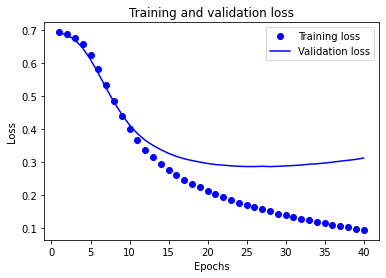

In [17]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# “bo”代表 "蓝点"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b代表“蓝色实线”
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

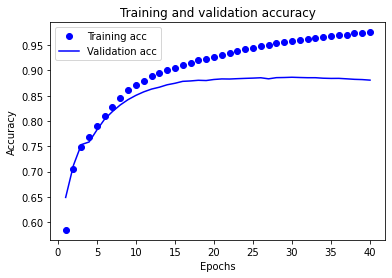

In [18]:
plt.clf()   # 清除数字

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

在该图中，点代表训练损失值（loss）与准确率（accuracy），实线代表验证损失值（loss）与准确率（accuracy）。

注意训练损失值随每一个 epoch *下降*而训练准确率（accuracy）随每一个 epoch *上升*。这在使用梯度下降优化时是可预期的——理应在每次迭代中最小化期望值。

验证过程的损失值（loss）与准确率（accuracy）的情况却并非如此——它们似乎在 20 个 epoch 后达到峰值。这是过拟合的一个实例：模型在训练数据上的表现比在以前从未见过的数据上的表现要更好。在此之后，模型过度优化并学习*特定*于训练数据的表示，而不能够*泛化*到测试数据。

对于这种特殊情况，我们可以通过在 20 个左右的 epoch 后停止训练来避免过拟合。稍后，您将看到如何通过回调自动执行此操作。